In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from bintrees import BinaryTree
from tqdm.notebook import tqdm_notebook
import pickle

from common import VoterData, get_random_dv, get_random_hs, HOUSE_REP_TO_POP
from solver import option1_find_f, F_ERROR, MAX_F, MIN_F

In [52]:
vd = VoterData(3, [0, 0], [4,10,5], [0.51, 0.49, 0.501])

In [54]:
option1_find_f(vd, True)

(Fairness(f_hi=4.0, f_lo=1.0), <F_ERROR.none: 0>)

In [55]:
option1_find_f(vd, False)

(Fairness(f_hi=1.0, f_lo=0.0), <F_ERROR.none: 0>)

In [4]:
np.random.seed(7)
ns = 50
total = 0

# stores upper bound : vd
bounds_upper = BinaryTree()

# sample 1000 voter datas such that the fairness 
# must be non-trivial for an oracle response of Dems and Reps
pbar = tqdm_notebook(total=1000)
while total != 1000:
    stop = []
    stoh = []
    stodv = []
    for _ in range(ns):
        dv = get_random_dv()
        hs = get_random_hs(normal=True, frac=True)
        stodv.append(dv)
        stoh.append(hs)
        stop.append(hs * HOUSE_REP_TO_POP)
    vd = VoterData(ns, stop, stoh, stodv)
    
    # both responses should be valid
    f1, err1 = option1_find_f(vd, True)
    f2, err2 = option1_find_f(vd, False)
    if err1 != F_ERROR.none or err2 != F_ERROR.none:
        continue
    assert ((abs(f1.f_hi - f2.f_lo) < 1e-3) or (abs(f1.f_lo - f2.f_hi) < 1e-3))
    
    if f1.f_hi not in bounds_upper:
        bounds_upper.insert(f1.f_hi, vd)
        pbar.update(1)
        total += 1
    if f2.f_hi not in bounds_upper:
        bounds_upper.insert(f2.f_hi, vd)
        pbar.update(1)
        total += 1

pbar.close()

In [5]:
def get_pop(vd):
    h = np.array(vd.stoh)
    return (np.array(vd.stodv) * h).sum() / h.sum()

In [6]:
npops = []
for t in bounds_upper:
    npops.append(get_pop(bounds_upper[t]))

(array([  5.,  21.,  79., 195., 276., 238., 120.,  56.,   7.,   3.]),
 array([0.47688444, 0.48167066, 0.48645688, 0.4912431 , 0.49602932,
        0.50081554, 0.50560175, 0.51038797, 0.51517419, 0.51996041,
        0.52474663]),
 <a list of 10 Patch objects>)

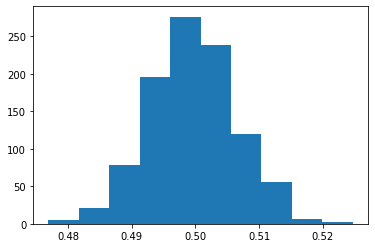

In [7]:
plt.hist(npops)

In [8]:
ret = bounds_upper.keys()
v = [i for i in ret]

(array([140., 124., 108.,  89., 112.,  92., 110.,  68.,  72.,  85.]),
 array([1.84617363e-04, 4.00166156e-01, 8.00147694e-01, 1.20012923e+00,
        1.60011077e+00, 2.00009231e+00, 2.40007385e+00, 2.80005539e+00,
        3.20003692e+00, 3.60001846e+00, 4.00000000e+00]),
 <a list of 10 Patch objects>)

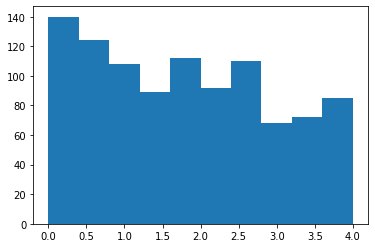

In [9]:
plt.hist(v)

In [10]:
f = open(f'o1_ns={ns}_rand.pkl', 'wb')
pickle.dump(bounds_upper, f)
f.close()